In [ ]:
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import keras.utils as image
from keras.applications import MobileNetV3Large
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

2024-03-26 13:41:10.035521: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-26 13:41:10.117119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 13:41:10.117283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 13:41:10.121160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 13:41:10.138824: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'

In [3]:
image_size=(224,224,3)

In [4]:
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [6]:
train_images.shape

(7459, 224, 224, 3)

In [7]:
# Load MobileNetV3 (large) with pre-trained weights on ImageNet
base_mobilenetv3_large = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='None')

# Add Global Average Pooling (GAP) layer
x = base_mobilenetv3_large.output
x = GlobalAveragePooling2D()(x)

# Create the model
mobilenetv3_large_with_gap = Model(inputs=base_mobilenetv3_large.input, outputs=x)


2024-03-26 13:41:51.936733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 915 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:88:00.0, compute capability: 8.0
2024-03-26 13:41:51.970614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7803 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0
2024-03-26 13:41:51.976240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38374 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0
2024-03-26 13:41:51.980561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 37955 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bus i

In [8]:
# Function to extract features in batches
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [9]:

batch_size = 8
# Extract features using MobileNetV3 (large)
train_features = extract_features(mobilenetv3_large_with_gap, train_images, batch_size)
test_features = extract_features(mobilenetv3_large_with_gap, test_images, batch_size)

2024-03-26 13:41:57.211621: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-26 13:41:57.372236: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1/1 [==============================] - 3s 3s/step


2024-03-26 13:41:58.349403: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-26 13:41:58.416557: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


1/1 [==============================] - 0s 421ms/step


In [10]:
test_features[0]

array([-0.00000000e+00, -0.00000000e+00, -5.37894724e-04, -0.00000000e+00,
       -1.15164757e-01, -0.00000000e+00, -0.00000000e+00, -1.04775898e-01,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  7.48119950e-01,
       -0.00000000e+00, -2.92675220e-03, -2.96112858e-02, -0.00000000e+00,
       -1.07156888e-01, -6.23601228e-02, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  4.81412792e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -4.36154157e-02, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        4.88336906e-02, -0.00000000e+00,  3.21038580e+00, -9.42145959e-02,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.40808135e-01, -1.34224087e-01, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [11]:
# # Define the parameter grid
# param_grid = {'n_neighbors': [8], 'metric': ['minkowski']}
# Define the parameter grid for KNN
knn_param_grid = {'n_neighbors' : range(2,15),
               'metric' : ['minkowski','euclidean','manhattan']}

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Use GridSearchCV to find the best parameters for KNN
grid_search = GridSearchCV(knn_classifier, knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_features, train_labels)

# Get the best parameters
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']


In [12]:
# Use the best parameters to train the final model
final_knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric=best_metric)
start_time = time.time()
final_knn_classifier.fit(train_features, train_labels)
train_time = time.time() - start_time

# Predict labels for the test set
knn_predictions = final_knn_classifier.predict(test_features)

# Evaluate accuracy
knn_accuracy = accuracy_score(test_labels, knn_predictions)
print("Best KNN Parameters:", grid_search.best_params_)
print("Best KNN Accuracy:", knn_accuracy)

# Additional evaluation metrics
precision = precision_score(test_labels, knn_predictions, average='weighted')
recall = recall_score(test_labels, knn_predictions, average='weighted')
f1 = f1_score(test_labels, knn_predictions, average='weighted')


print("Train Time (sec):", train_time)
# If you used GridSearchCV, you can access the training time with `cv_results_`
grid_train_time = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]
print("Train Time (sec) Grid:", grid_train_time)

Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best KNN Accuracy: 0.9811912225705329
Train Time (sec): 0.011730432510375977
Train Time (sec) Grid: 0.0509794553120931


In [13]:
# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(test_labels, knn_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Matthews Correlation Coefficient (MCC): 0.9781242937680991


In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, knn_predictions)
precision = precision_score(test_labels, knn_predictions, average='weighted')

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# False omission rate
FOR_ = FN/(FN+TN)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [15]:
# Compute True Positive Rate (TPR), True Negative Rate (TNR), False Positive Rate (FPR)

# Display results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("True Positive Rate (TPR):", np.mean(TPR))
print("True Negative Rate (TNR):", np.mean(TNR))
print("False Positive Rate (FPR):", np.mean(FPR))
print("False Negative Rate (FNR):", np.mean(FNR))
print("False Discovery Rate (FDR):", np.mean(FDR))
print("False Omission Rate (FOR):", np.mean(FOR_))
print("Overall accuracy (ACC):",np.mean(ACC))


Precision: 0.9811601822152747
Recall: 0.9811912225705329
F1 Score: 0.9806834126149716
True Positive Rate (TPR): 0.959255467150204
True Negative Rate (TNR): 0.9992162999584571
False Positive Rate (FPR): 0.0007837000415428544
False Negative Rate (FNR): 0.04074453284979601
False Discovery Rate (FDR): 0.043118049360689865
False Omission Rate (FOR): 0.0008010825059092477
Overall accuracy (ACC): 0.9984952978056427


In [16]:
#Feature space (number of pixels in each image)
feature_space = train_images.shape
print("Feature Space:", feature_space)

# Accuracy for optimization algorithm (GridSearchCV)
optimization_accuracy = grid_search.best_score_
print("Optimization Algorithm Accuracy:", optimization_accuracy)


Feature Space: (7459, 224, 224, 3)
Optimization Algorithm Accuracy: 0.9737229463416254


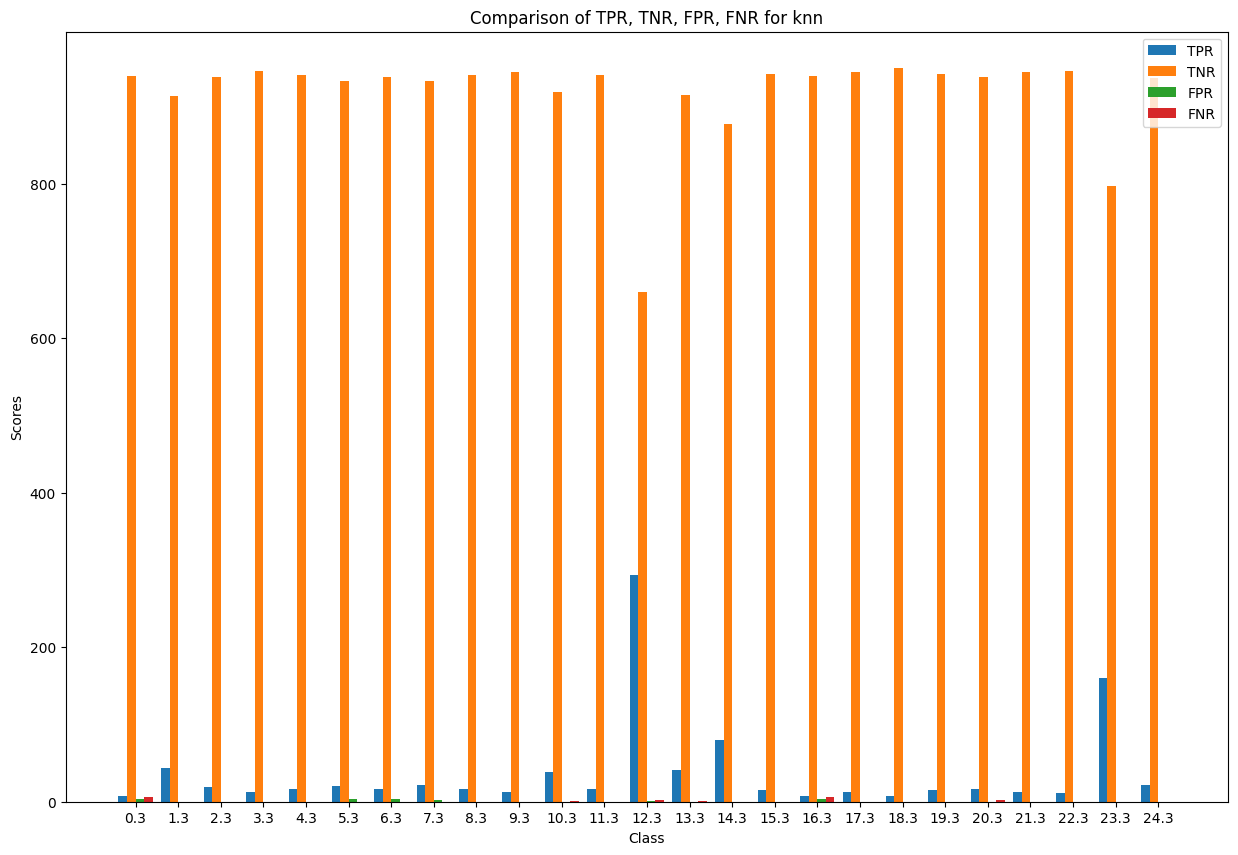

In [17]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for knn')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

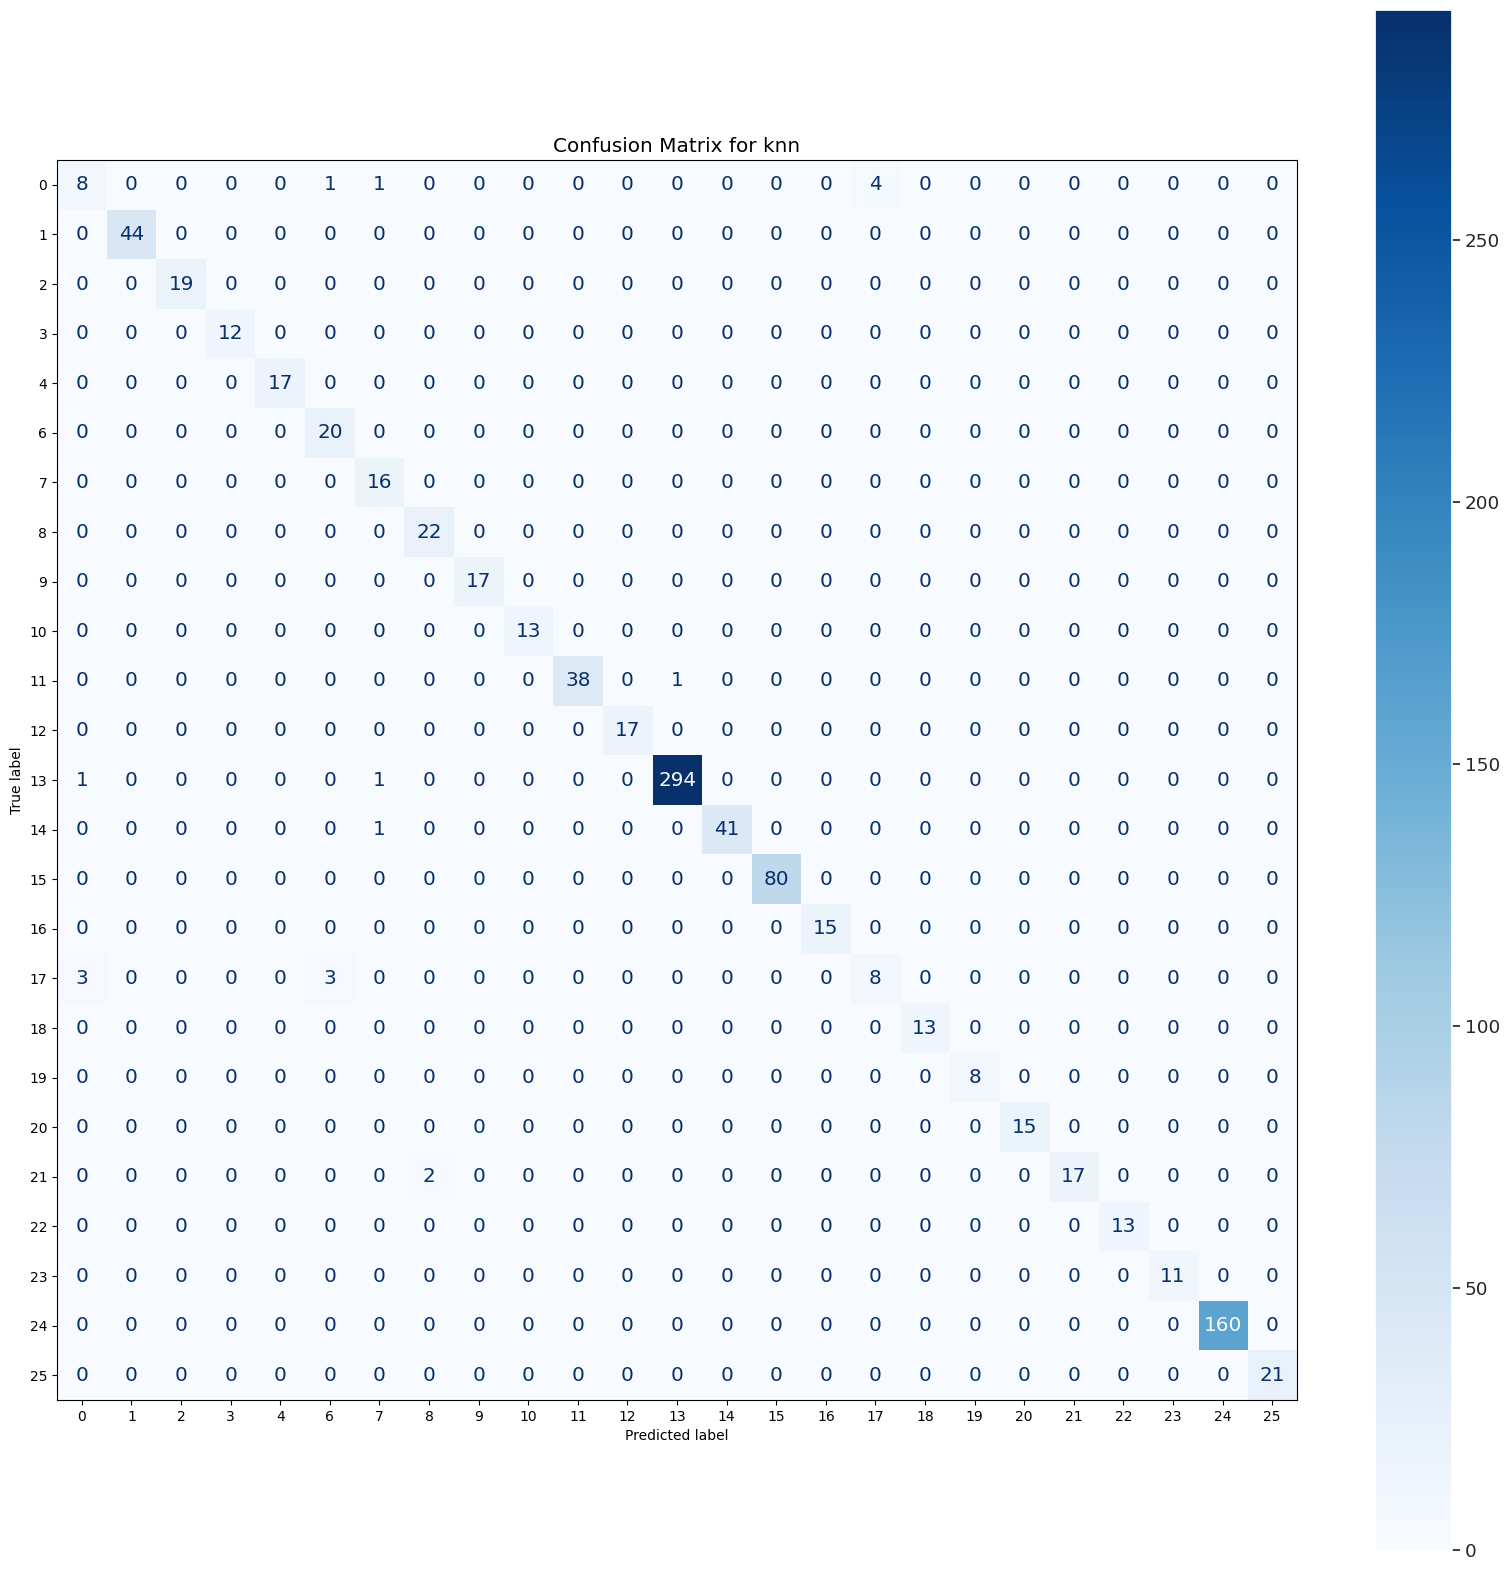

: 

In [18]:
# Plot Confusion Matrix for Naive Bayes
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for knn')
plt.show()